<a href="https://colab.research.google.com/github/Aishika3/Image_Classification_CNN/blob/main/Image_Classififcation_QNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using cuda device
Epoch 1
Epoch 2
Epoch 3
Train accuracy: 0.555, loss: 0.690
Test accuracy: 0.561, loss: 0.689


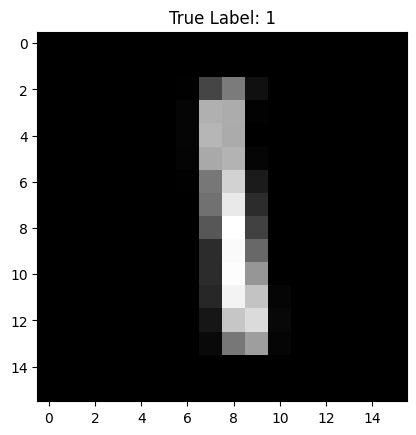

Predicted Label: 1


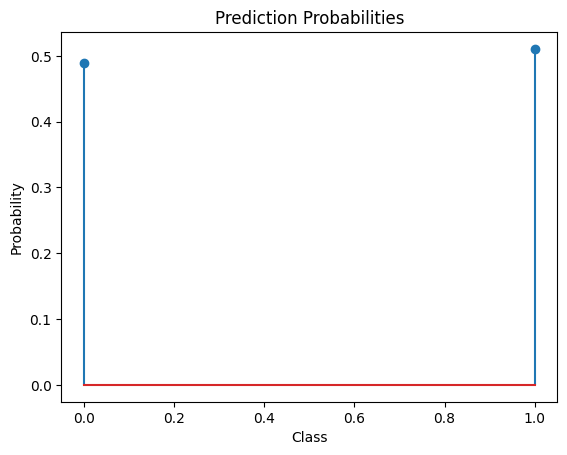

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Dummy quantum circuit simulator (replace with real one if available)
class quantum_circuit:
    def __init__(self, num_qubits, state_vector):
        self.state = state_vector  # [dim, batch]

    def Ry_layer(self, angles): pass
    def cx_linear_layer(self): pass
    def probabilities(self):
        return self.state.abs() ** 2  # dummy: returns probabilities

# Setup
size = 16
transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def load_dataset(name="MNIST"):
    if name == "FashionMNIST":
        train_dataset = datasets.FashionMNIST(root="FashionMNIST", train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root="FashionMNIST", train=False, download=True, transform=transform)
    else:
        train_dataset = datasets.MNIST(root="MNIST", train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root="MNIST", train=False, download=True, transform=transform)
    return train_dataset, test_dataset

def generate_subset(dataset):
    return [(x, torch.tensor(float(y), dtype=torch.float32)) for x, y in dataset if y in [0, 1]]

train_dataset, test_dataset = load_dataset("MNIST")
train_dataset = generate_subset(train_dataset)
test_dataset = generate_subset(test_dataset)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Quantum network
n = int(2 * np.log2(size))
dim = 2 ** n
last_qubit_proj = torch.tensor([(1 + (-1) ** i) / 2 for i in range(dim)], dtype=torch.float32, device=device)

class QNN(nn.Module):
    def __init__(self, n, L):
        super().__init__()
        self.flatten = nn.Flatten()
        angles = torch.empty((L, n), dtype=torch.float64)
        torch.nn.init.uniform_(angles, -0.01, 0.01)
        self.angles = nn.Parameter(angles)

    def forward(self, x):
        x = self.flatten(x)
        x = x / torch.linalg.norm(x.clone(), ord=2, dim=1, keepdim=True)
        qc = quantum_circuit(num_qubits=n, state_vector=x.T)
        for l in range(self.angles.shape[0]):
            qc.Ry_layer(self.angles[l].to(torch.cfloat))
            qc.cx_linear_layer()
        x = torch.real(qc.probabilities())  # [dim, batch]
        x = torch.matmul(x.T, last_qubit_proj.detach())  # [batch]
        x = x.unsqueeze(1)  # [batch, 1]
        x = x.clone().detach().requires_grad_(True)  # ensures gradient flow
        return x

# Train & eval functions
def performance_estimate(dataset, model, loss_fn, tag="test"):
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).view(-1, 1)
            out = model(X)
            loss += loss_fn(out, y).item()
            pred = torch.stack([1 - out, out], dim=1).squeeze()
            correct += (pred.argmax(1) == y.view(-1)).sum().item()
    acc = correct / len(dataset)
    loss /= len(dataloader)
    print(f"{tag} accuracy: {acc:.3f}, loss: {loss:.3f}")
    return acc, loss

def training(dataset, batch_size, n, L, lr, weight_decay, epochs):
    model = QNN(n=n, L=L).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        model.train()
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device).view(-1, 1)
            out = model(X)
            loss = loss_fn(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model

# Run training
L = 3
batch_size = 64
model = training(train_dataset, batch_size=batch_size, n=n, L=L, lr=1e-3, weight_decay=1e-8, epochs=3)

# Evaluate
loss_fn = nn.BCELoss()
performance_estimate(train_dataset, model, loss_fn, 'Train')
performance_estimate(test_dataset, model, loss_fn, 'Test')

# Visualize prediction
idx = np.random.choice(len(test_dataset))
x = test_dataset[idx][0]
y_true = int(test_dataset[idx][1].item())

plt.imshow(x[0], cmap='gray')
plt.title(f"True Label: {y_true}")
plt.show()

out = model(x.unsqueeze(0).to(device)).detach().cpu().flatten()
prob = torch.stack([1 - out, out])
pred = prob.argmax().item()

print(f"Predicted Label: {pred}")
plt.stem(np.arange(2), prob)
plt.title("Prediction Probabilities")
plt.ylabel("Probability")
plt.xlabel("Class")
plt.show()
